## EDA 할 내용
- 이미지 당 단어 개수 분포 
- 전체 단어 길이 분포
- image width, height
- 전체 BBOX 크기 분포
    - 넓이 기준
- 전체 태그 별 분포
    - 언어
    - orientation
    - word tag
    - image tag
- aspect ratio (가로/세로)
   - polygon은 rectify하기

In [ ]:
'''
original code source : https://www.kaggle.com/aidapearson/eda-starter-notebook
'''

In [1]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [2]:
# 보류
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [4]:
# gt file과 raw image file path를 이용해 데이터를 불러온다. 아래 경로는 예시.
# data = read_json("/opt/ml/dataset/annotation.json")
data = read_json("/opt/ml/dataset_revised/ufo/annotation.json")

In [5]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        # print(f"quads[:, {i}] - quads[:, {j}] = {quads[:, i]} - {quads[:, j]} = {quads[:, i] - quads[:, j]}")
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    # print(f"dists 1 = {dists}")

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) widths, heights into separate dim
    # print(f"dists 2 = {dists}")
    # print(f"return = {np.rint(dists.mean(axis=-1)).astype(int)}")
    return np.rint(dists.mean(axis=-1)).astype(int)

In [6]:
def rectify_poly(poly, direction):
    """일반 polygon형태인 라벨을 크롭하고 rectify해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        image: np.ndarray opencv 포멧의 이미지
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 사이즈.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0]
        w = size[:, 1]
        # print(h, w)
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction == 'Horizontal':
        h = sizes[:, 0].max()
        widths = sizes[:, 1]
        w = np.sum(widths)
        # print(np.stack((h,w)).reshape(2,-1))
        return np.stack((h,w)).reshape(2,-1)
    elif direction == 'Vertical':
        heights = sizes[:, 0]
        w = sizes[:, 1].max()
        h = np.sum(heights)
        # print(np.stack((h,w)).reshape(2,-1))
        return np.stack((h,w)).reshape(2,-1)
    else:
        h = sizes[:, 0]
        w = sizes[:, 1]
        # print(np.stack((h,w),-1))
        return np.stack((h,w),-1)

In [19]:
df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_tags = []
aspect_ratio = []
ver_string = []

for image_key, image_value in data["images"].items():
    df['image'].append(image_key)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] # our data does not inlcude multi-tag images 
    word_ann = image_value['words']
    count_ill = 0 
    for idx, word in enumerate(word_ann.values()):
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages] # our data does not inlcude multi-language words
            if word['word_tags'] != None:
                word_tags.extend(word['word_tags'][:])
            elif word['word_tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])

            if poly.shape[0] % 2 == 1:
                print(idx, image_key, poly)

            size = rectify_poly(poly, word['orientation'])
            if word['orientation'] == 'Horizontal':
                hor_sizes.append(size)
            elif word['orientation'] == 'Vertical':
                ver_sizes.append(size)
            else:
                irr_sizes.append(size)
            
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)
        
all_sizes = hor_sizes + ver_sizes + irr_sizes
quad_area = [all_sizes[i][0]*all_sizes[i][1] for i in range(len(all_sizes))]
total_area = []
for s in quad_area:
    if s.shape[0] == 1:
        total_area.append(np.sum(s[0])) 
    else:
        total_area.append(np.sum(s))

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

25 14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG [[ 935 1112]]


AssertionError: 

In [18]:
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ','.join(map(str, x)))
image_df

,image,word_counts,image_tags
0,14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG,43,
1,1631619209578-10.jpg,4,
2,1632643837411-12.jpg,20,
3,1632644162889-2.jpg,4,
4,1632651294334-28.jpg,11,
...,...,...,...
1247,IMG_7092.jpeg,1,
1248,IMG_7122.jpeg,16,
1249,IMG_7215.jpeg,12,
1250,IMG_7239.jpeg,15,


In [19]:
image_df['image_tags'].describe()

count     1252
unique       1
top           
freq      1252
Name: image_tags, dtype: object

In [20]:
# check if there are image with multiple image tags (which would apper as e.g. "document, outfocus")
set(image_df['image_tags'].tolist())

{''}

In [21]:
image_df.describe()

,word_counts
count,1252.000000
mean,16.793930
std,24.477772
min,0.000000
25%,3.000000
50%,8.000000
75%,19.000000
max,257.000000


In [28]:
image_df['word_counts'].groupby(image_df['word_counts']).count()

word_counts
0      87
1      90
2      83
3      85
4      64
       ..
176     1
181     1
183     1
233     1
257     1
Name: word_counts, Length: 105, dtype: int64

In [29]:
# just for checking
list(data['images'].keys())[0]

'14B9AA34-3F88-40E2-A3E8-6A2ED0CAE7E1.JPG'

In [30]:
first_img = list(data['images'].keys())[0]
data["images"][first_img].keys()

dict_keys(['paragraphs', 'words', 'chars', 'tags', 'relations', 'license_tag'])

In [32]:
# image width, height 
# g = sns.jointplot("image_width", "image_height", data=image_df, kind="kde", space=0, color="r")
# g.set_axis_labels("Image Width", "Image Height")

In [33]:
def create_count_df(df, field, index):
    count=df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()
    

/tmp/ipykernel_6944/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


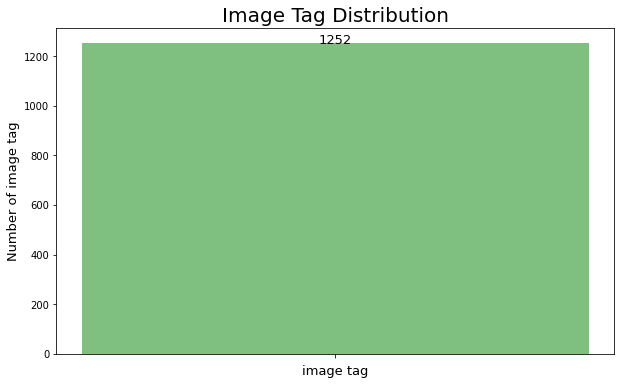

In [34]:
img_tag_df = create_count_df(df=image_df, field='image_tags', index='image')
plot_count_df(df=img_tag_df, field='image_tags', random_sample=False, color='g', rotation=0, xlabel='image tag', \
              ylabel='Number of image tag', title='Image Tag Distribution')

/tmp/ipykernel_6944/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


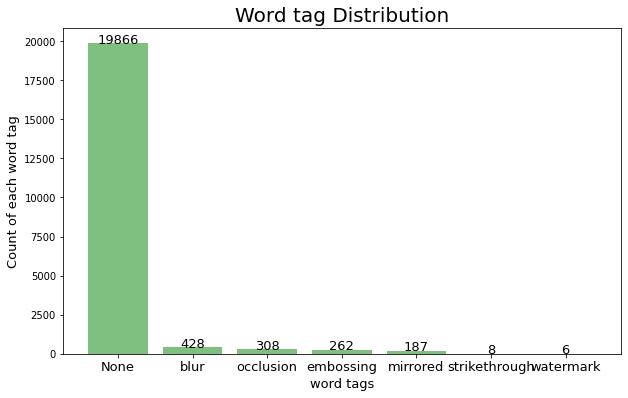

In [35]:
# Total word tags 
word_tag_df = pd.DataFrame(word_tags, columns = ['word_tags'])
word_tag_df['index'] = [i for i in range(len(word_tags))]
word_tag_df = create_count_df(word_tag_df, field='word_tags',index='index')
plot_count_df(df=word_tag_df, field='word_tags', random_sample=False, color='g', rotation=0, xlabel='word tags', \
              ylabel='Count of each word tag', title='Word tag Distribution')

In [36]:
word_tag_df.iloc[0]['word_tags_count']

19866

In [37]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


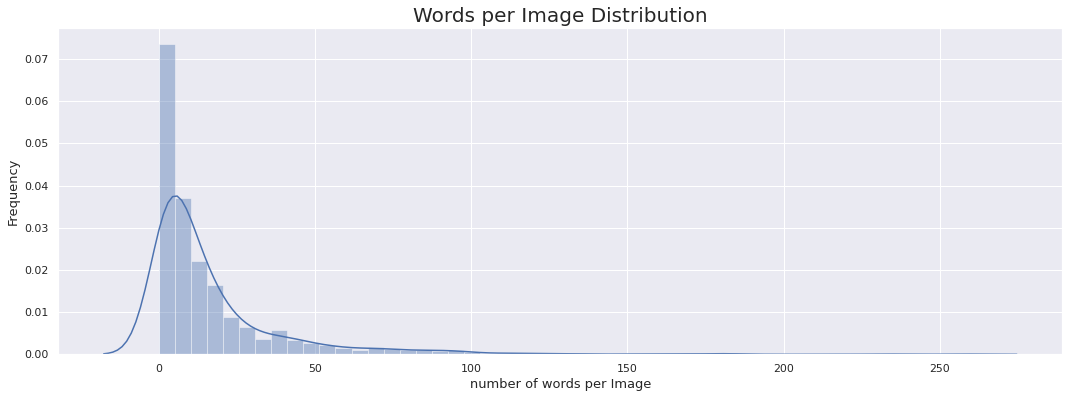

In [38]:
plot_dist(df=image_df, field='word_counts', bins=50, color='b', xlabel='number of words per Image', \
          ylabel='Frequency', title='Words per Image Distribution')

In [49]:
word_df ={}

word_df['orientation'] = orientation
word_df['language'] = languages
word_df['index'] = [i for i in range(len(word_df['orientation']))]

In [50]:
word_df = pd.DataFrame.from_dict(word_df)

In [51]:
word_df['language'] = word_df['language'].apply(lambda x: ','.join(map(str, x)))
word_df

,orientation,language,index
0,Horizontal,EN,0
1,Horizontal,EN,1
2,Horizontal,EN,2
3,Horizontal,KO,3
4,Horizontal,KO,4
...,...,...,...
21021,Horizontal,KO,21021
21022,Horizontal,EN,21022
21023,Horizontal,"KO,EN",21023
21024,Horizontal,KO,21024


In [52]:
word_df.columns

Index(['orientation', 'language', 'index'], dtype='object')

/tmp/ipykernel_6944/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


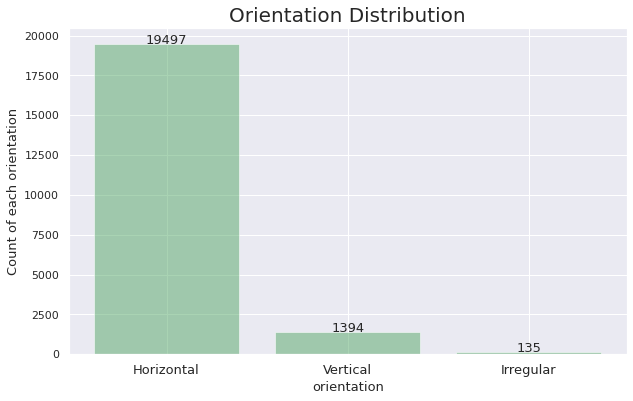

In [53]:
orientation = create_count_df(df=word_df, field='orientation', index='index')
plot_count_df(df=orientation, field='orientation', random_sample=False, color='g', rotation=0, xlabel='orientation', \
              ylabel='Count of each orientation', title='Orientation Distribution')

In [54]:
orientation

,orientation,orientation_count
0,Horizontal,19497
1,Vertical,1394
2,Irregular,135


/tmp/ipykernel_6944/2687934052.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


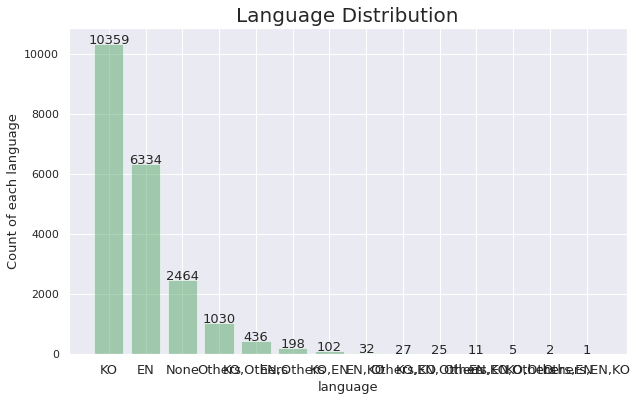

In [55]:
# None means it's either a different language or a special symbol
lang = create_count_df(df=word_df, field='language', index='index')
plot_count_df(df=lang, field='language', random_sample=False, color='g', rotation=0, xlabel='language', \
              ylabel='Count of each language', title='Language Distribution')

In [57]:
def plot_dist_list(target_list, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(target_list, bins=bins, color=color, ax=ax)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()